In [2]:
%matplotlib notebook
import os
import sys
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from rdkit import Chem

paths = [os.path.abspath(path) for path in ["..", "../Source"]]
for path in paths:
    if path not in sys.path:
        sys.path.append(path)

In [3]:
transition_metals = ["Mg", "Al", "Ca", "Mn", "Fe", "Co", "Ni", "Cu", "Zn", "Y", "Ag", "Cd", "Hg", "Pb", "Bi"]
Ln_metals = ["La", "Ce", "Pr", "Nd", "Sm", "Eu", "Gd", "Tb", "Dy", "Ho", "Er", "Tm", "Yb", "Lu"]
Ac_metals = ["Th", "Am", "Cm", "Bk", "Cf"]  # "U", "Pu",
all_metals = transition_metals + Ln_metals + Ac_metals

In [4]:
def read_results(path):
    result = {}
    with open(os.path.join(path, "metrics.json"), "r") as file:
        f = json.load(file)
    for key in f:
        if key in ["train_r2_score", "valid_r2_score", "test_r2_score"]:
            result[key] = f[key]
    return result

In [5]:
def show_results(cases, colors=("tab:blue", "tab:orange", "tab:green", "tab:red"),
                 width=0.2, y_lim=None, title="Scores in different cases", y_label="$R^2$ score", fmt="%.2lf",
                 labels=("train", "valid", "test"), figsize=(10, 5), float_fontsize=10, legend_loc="best",
                 fig=None, ax=None, savename=None):

    x = np.arange(len(labels))
    width = width
    
    if fig is None:
        fig, ax = plt.subplots(figsize=figsize)

    bars = []
    for i, (case, label) in enumerate(cases):
        bars += [ax.bar(x + width*(-len(cases)/2 + 0.5 + i), case.values(), width, label=label)]
        ax.bar_label(bars[-1], padding=3, fmt=fmt, fontsize=float_fontsize)

    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.set_xticks(x, labels)
    ax.legend(loc=legend_loc)
    if y_lim:
        ax.set_ylim(*y_lim)

    fig.tight_layout()
    plt.show()
    if savename:
        fig.savefig(savename)
    return fig, ax

In [6]:
def read_opuna_results(path):
    df = pd.read_csv(path, index_col="Unnamed: 0")
    df["user_attrs_metrics"] = df["user_attrs_metrics"].apply(lambda s: json.loads(s.replace("'", "\"")))

    for ind in df.index:
        for key in df["user_attrs_metrics"][ind]:
            df.loc[ind, key] = float(df["user_attrs_metrics"][ind][key])

    del df["user_attrs_metrics"]
    return df

## Optuna results

In [5]:
from optimize_hyperparameters import DictHeteroParams

df = read_opuna_results("../Output/optuna_results_2022_11_17_21_49_14.csv")
df = df.sort_values(by="value", ascending=True, ignore_index=True)
all_param_dicts = [{} for i in df.index]
for i in df.index:
    trial_params = {}
    all_params = dict(df.loc[i])
    for key in all_params:
        if key.startswith("params_"):
            trial_params[key.replace("params_", "")] = all_params[key]
    for key, value in DictHeteroParams(trial_params).get().items():
        if key.startswith("n_"):
            continue
        if key.startswith("hidden_"):
            value = list(map(int, value))
        all_param_dicts[i][key] = value
df["model_params"] = all_param_dicts
df.head()

,number,value,datetime_start,datetime_complete,duration,params_conv_actf_name,params_conv_dropout,params_conv_features,params_conv_layer0,params_conv_layer1,...,train_r2_score,valid_r2_score,test_r2_score,train_mean_squared_error,valid_mean_squared_error,test_mean_squared_error,train_mean_absolute_error,valid_mean_absolute_error,test_mean_absolute_error,model_params
0,129,0.041820,2022-11-19 13:32:48.275585,2022-11-19 13:45:43.408166,0 days 00:12:55.132581,nn.Mish(),0.155344,75,256.0,NaN,...,0.871435,0.558078,0.836394,0.012166,0.041820,0.015184,0.083630,0.155224,0.101376,"{'hidden_metal': [30, 64, 256, 128, 256], 'hid..."
1,32,0.042204,2022-11-18 09:27:57.238496,2022-11-18 09:48:21.459308,0 days 00:20:24.220812,nn.PReLU(),0.099253,75,256.0,64.0,...,0.929379,0.554014,0.900774,0.006683,0.042204,0.009209,0.061454,0.154194,0.076137,"{'hidden_metal': [200, 128, 128, 64, 256], 'hi..."
2,86,0.044826,2022-11-19 02:56:01.224826,2022-11-19 03:09:40.183641,0 days 00:13:38.958815,nn.Mish(),0.065715,75,256.0,128.0,...,0.940754,0.526308,0.934209,0.005607,0.044826,0.006106,0.051888,0.153556,0.062070,"{'hidden_metal': [200, 64, 64, 64, 64, 128], '..."
3,15,0.045370,2022-11-18 04:02:43.268973,2022-11-18 04:18:54.469669,0 days 00:16:11.200696,nn.Softsign(),0.128176,75,256.0,NaN,...,0.908924,0.520566,0.891104,0.008619,0.045370,0.010106,0.064319,0.147674,0.074000,"{'hidden_metal': [30, 64, 256], 'hidden_conv':..."
4,100,0.047067,2022-11-19 06:00:13.165163,2022-11-19 06:16:36.996939,0 days 00:16:23.831776,nn.LeakyReLU(),0.055431,75,256.0,64.0,...,0.916635,0.502631,0.890357,0.007889,0.047067,0.010176,0.066947,0.152520,0.082941,"{'hidden_metal': [200, 64, 64, 64, 64, 128], '..."


In [6]:
df.sort_values(by="value", ascending=True, ignore_index=True)["model_params"][0]

{'hidden_metal': [30, 64, 256, 128, 256],
 'hidden_conv': [75, 256, 256],
 'hidden_linear': [256, 64, 256, 128, 256],
 'metal_dropout': 0.1001059901369454,
 'conv_dropout': 0.1553438602919989,
 'linear_dropout': 0.0010466950922097,
 'metal_ligand_unifunc': 'mean',
 'conv_layer': 'MFConv',
 'pooling_layer': 'global_max_pool',
 'conv_actf': 'nn.Mish()',
 'linear_actf': 'nn.SELU()',
 'linear_bn': False,
 'optimizer': 'Adam',
 'optimizer_parameters': {}}

## Scores of models

<IPython.core.display.Javascript object>


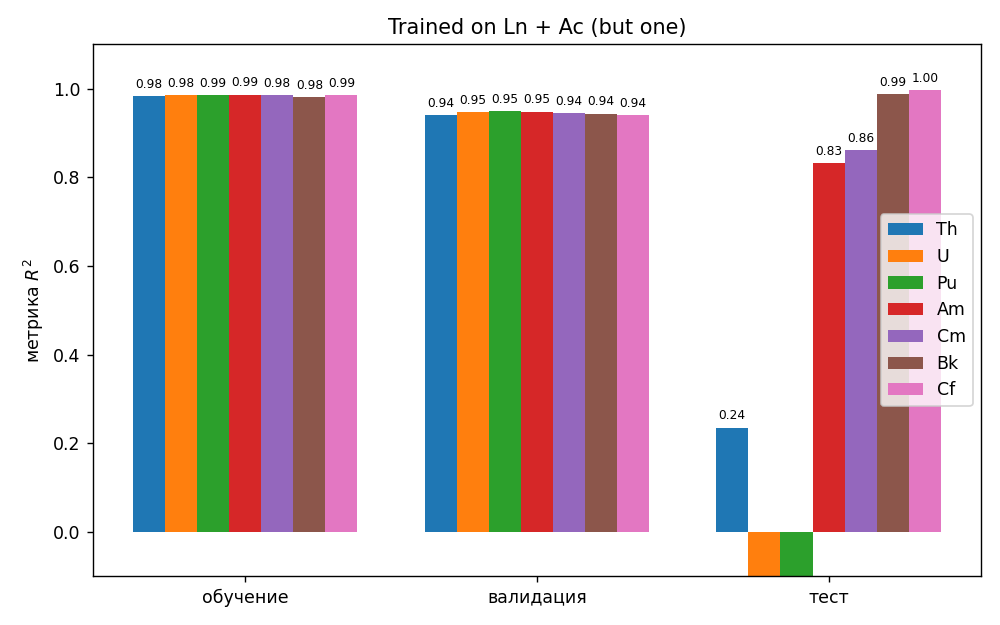

In [7]:
base_path = "../Output/LnAc_testonly/seed9"
cases = []

for Ac in ["Th", "U", "Pu", "Am", "Cm", "Bk", "Cf"]:
    for folder in os.listdir(os.path.join(base_path, Ac)):
        if folder.startswith(f"LnAc_{Ac}_1_"):
            cases += [(read_results(os.path.join(base_path, Ac, folder)), Ac)]

show_results(cases, width=0.11, y_lim=(-0.1, 1.1),
             float_fontsize=7,
             title="Trained on Ln + Ac (but one)",
             savename="trained_on_LnAc_1.png",
             labels=("обучение", "валидация", "тест"),
             figsize=(8, 5),
             y_label="метрика $R^2$",
             legend_loc="center right"
)
None

### General Model

<IPython.core.display.Javascript object>


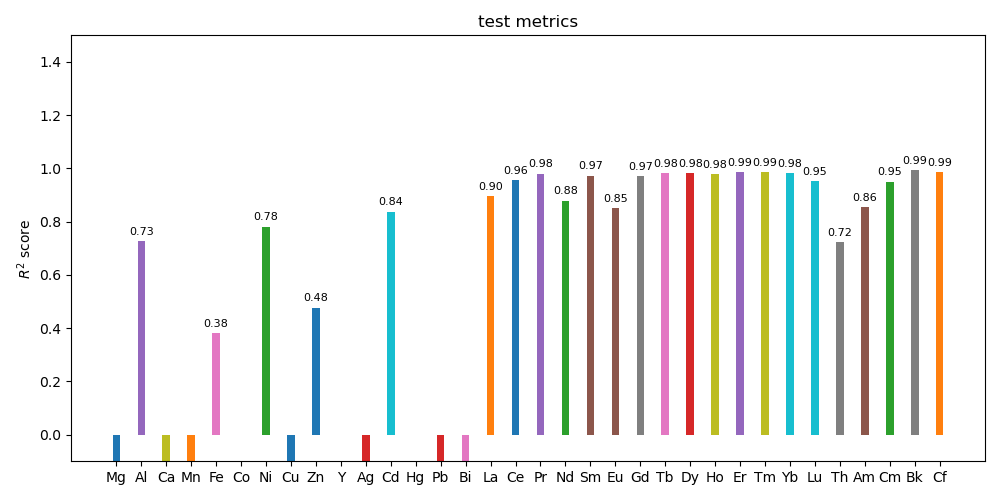

In [24]:
test_metrics = {}
for folder in os.listdir("../Output/GeneralModel"):
    metal = folder.split("_")[1]
    filename = os.path.join("../Output/GeneralModel", folder, "metrics.json")
    if not os.path.exists(filename):
        print(f"File doesn't exist: {filename}")
        continue
    with open(filename, "r") as file:
        test_metrics[metal] = json.load(file)["test_r2_score"]

fig, ax = plt.subplots(figsize=(10, 5))

width = 0.3
fmt="%.2lf"
float_fontsize=8

bars = []
for i, (metal, r2) in enumerate(test_metrics.items()):
    bars += [ax.bar([all_metals.index(metal)], [r2], width)]
    ax.bar_label(bars[-1], padding=3, fmt=fmt, fontsize=float_fontsize)

ax.set_ylabel("$R^2$ score")
ax.set_title("test metrics")
ax.set_xticks(range(len(all_metals)), all_metals)
ax.set_ylim(-0.1, 1.5)

fig.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


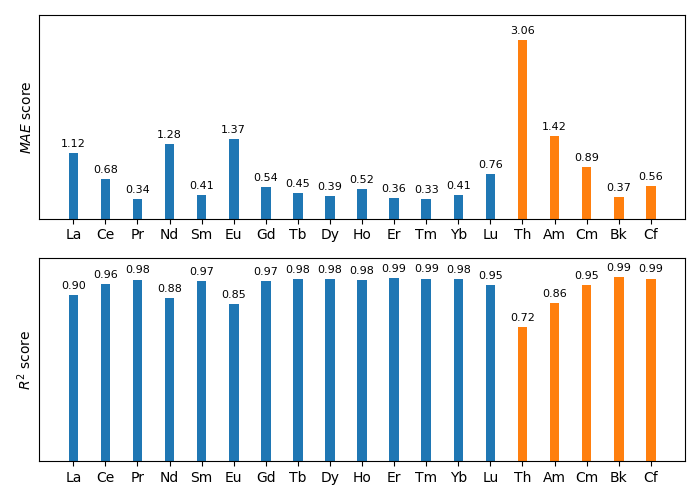

In [61]:
metals = Ln_metals + Ac_metals
r2_test_metrics = {}
mae_test_metrics = {}
for folder in os.listdir("../Output/GeneralModel"):
    metal = folder.split("_")[1]
    filename = os.path.join("../Output/GeneralModel", folder, "metrics.json")
    if metal not in metals: continue
    if not folder.startswith("General_"): continue
    if not os.path.exists(filename):
        print(f"File doesn't exist: {filename}")
        continue
    with open(filename, "r") as file:
        metrics = json.load(file)
        r2_test_metrics[metal] = metrics["test_r2_score"]
        mae_test_metrics[metal] = metrics["test_mean_absolute_error"]

fig, ax = plt.subplots(2, 1, figsize=(7, 5))

width = 0.3
fmt="%.2lf"
float_fontsize=8

bars = []
color = ["C0" if metal in Ln_metals else "C1" for metal in r2_test_metrics.keys()]
ind = np.array([metals.index(metal) for metal in r2_test_metrics.keys()])
r2_plot = [r2 for r2 in r2_test_metrics.values()]
mae_plot = [mae for mae in mae_test_metrics.values()]
bars += [ax[1].bar(ind, r2_plot, width, color=color)]
ax[1].bar_label(bars[-1], padding=3, fmt=fmt, fontsize=float_fontsize)

bars += [ax[0].bar(ind, mae_plot, width, color=color)]
ax[0].bar_label(bars[-1], padding=3, fmt=fmt, fontsize=float_fontsize)

ax[1].set_ylabel("$R^2$ score")
ax[1].set_ylim(0, 1.1)
ax[1].set_yticks([])

ax[0].set_ylabel("$MAE$ score")
ax[0].set_ylim(0, 3.5)
ax[0].set_yticks([])

ax[1].set_xticks(range(len(metals)), metals)
ax[0].set_xticks(range(len(metals)), metals)

fig.tight_layout()
plt.show()

### MEGNet model

<IPython.core.display.Javascript object>


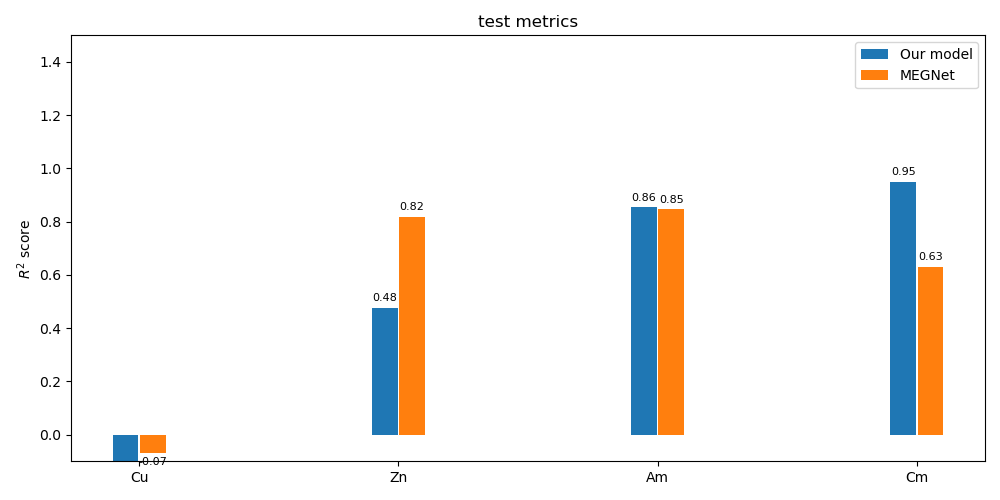

In [19]:
metals = ["Cu", "Zn", "Am", "Cm"]
general_metrics = {}
for metal in metals:
    for folder in os.listdir("../Output/GeneralModel"):
        if folder.startswith(f"General_{metal}"):
            filename = os.path.join("../Output/GeneralModel", folder, "metrics.json")
            with open(filename, "r") as file:
                general_metrics[metal] = json.load(file)["test_r2_score"]
                break
    
megnet_metrics = {}
for metal in metals:
    for folder in os.listdir("../Output"):
        if folder.startswith(f"Megnet_{metal}"):
            filename = os.path.join("../Output", folder, "metrics.json")
            with open(filename, "r") as file:
                megnet_metrics[metal] = json.load(file)["test_r2_score"]
                break

fig, ax = plt.subplots(figsize=(10, 5))

width = 0.1
fmt="%.2lf"
float_fontsize=8

bars = []
bars += [ax.bar([i - 1.05*width/2 for i in range(len(metals))],
                [general_metrics[metal] for i, metal in enumerate(metals)], width, label="Our model")]
bars += [ax.bar([i + 1.05*width/2 for i in range(len(metals))],
                [megnet_metrics[metal] for i, metal in enumerate(metals)], width, label="MEGNet")]
ax.bar_label(bars[0], padding=3, fmt=fmt, fontsize=float_fontsize)
ax.bar_label(bars[1], padding=3, fmt=fmt, fontsize=float_fontsize)

ax.set_ylabel("$R^2$ score")
ax.set_title("test metrics")
ax.set_xticks(range(len(metals)), metals)
ax.set_ylim(-0.1, 1.5)
ax.legend()

fig.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


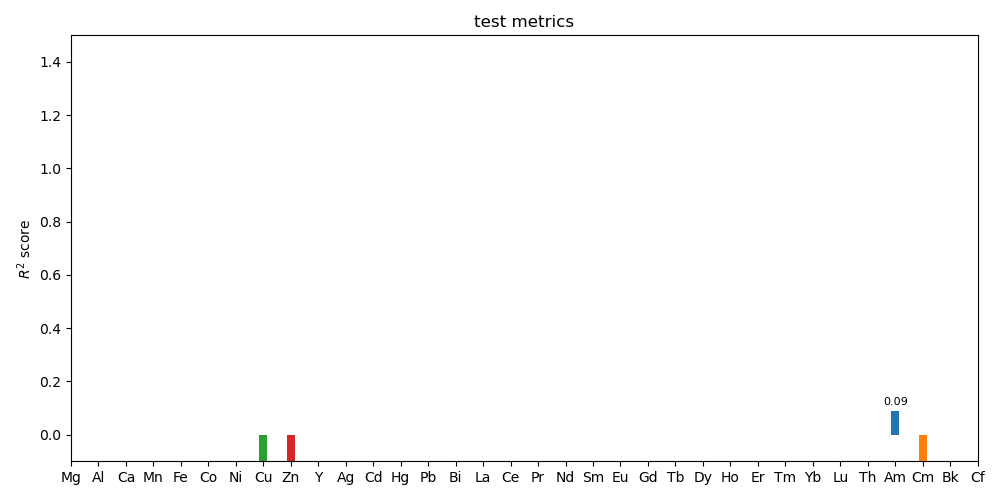

In [59]:
import torch
metals = all_metals
test_metrics = {}
for folder in os.listdir("../Output/GeneralModelAtt"):
    metal = folder.split("_")[0]
    filename = os.path.join("../Output/GeneralModelAtt", folder, "metrics.json")
    if not os.path.exists(filename):
        print(f"File doesn't exist: {filename}")
        continue
    with open(filename, "r") as file:
        test_metrics[metal] = json.load(file)["test_r2_score"]

fig, ax = plt.subplots(figsize=(10, 5))

width = 0.3
fmt="%.2lf"
float_fontsize=8

bars = []
for i, (metal, r2) in enumerate(test_metrics.items()):
    bars += [ax.bar([metals.index(metal)], [r2], width)]
    ax.bar_label(bars[-1], padding=3, fmt=fmt, fontsize=float_fontsize)

ax.set_ylabel("$R^2$ score")
ax.set_title("test metrics")
ax.set_xticks(range(len(metals)), metals)
ax.set_ylim(-0.1, 1.5)

fig.tight_layout()
plt.show()

### With conditions in metal vector

<IPython.core.display.Javascript object>


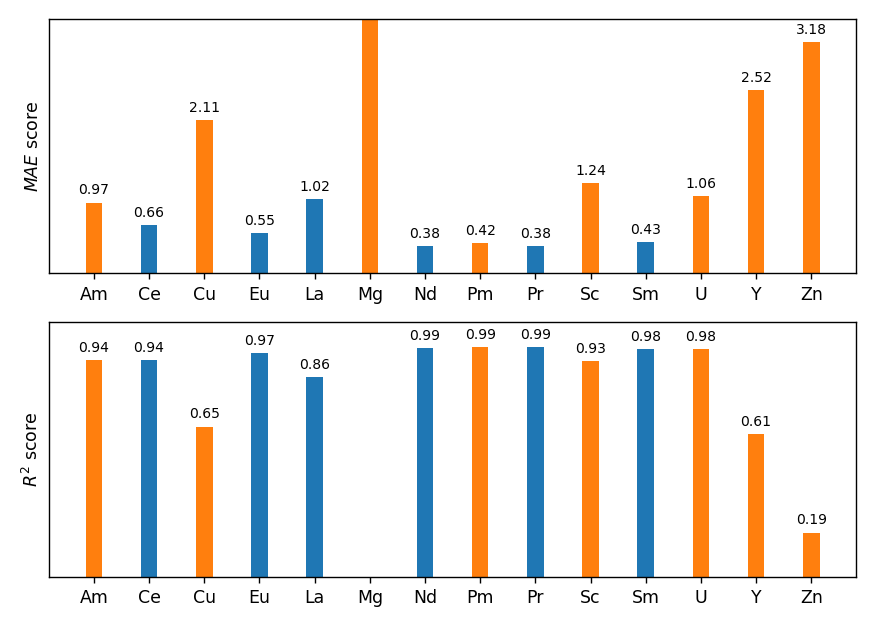

In [8]:
metals = []
r2_test_metrics = {}
mae_test_metrics = {}
for folder in os.listdir("../Output/WithCond"):
    metal = folder.split("_")[1]
    metals += [metal]
    filename = os.path.join("../Output/WithCond", folder, "metrics.json")
    if metal not in metals: continue
    if not folder.startswith("General_"): continue
    if not os.path.exists(filename):
        print(f"File doesn't exist: {filename}")
        continue
    with open(filename, "r") as file:
        metrics = json.load(file)
        r2_test_metrics[metal] = metrics["test_r2_score"]
        mae_test_metrics[metal] = metrics["test_mean_absolute_error"]

fig, ax = plt.subplots(2, 1, figsize=(7, 5))

width = 0.3
fmt="%.2lf"
float_fontsize=8

bars = []
color = ["C0" if metal in Ln_metals else "C1" for metal in r2_test_metrics.keys()]
ind = np.array([metals.index(metal) for metal in r2_test_metrics.keys()])
r2_plot = [r2 for r2 in r2_test_metrics.values()]
mae_plot = [mae for mae in mae_test_metrics.values()]
bars += [ax[1].bar(ind, r2_plot, width, color=color)]
ax[1].bar_label(bars[-1], padding=3, fmt=fmt, fontsize=float_fontsize)

bars += [ax[0].bar(ind, mae_plot, width, color=color)]
ax[0].bar_label(bars[-1], padding=3, fmt=fmt, fontsize=float_fontsize)

ax[1].set_ylabel("$R^2$ score")
ax[1].set_ylim(0, 1.1)
ax[1].set_yticks([])

ax[0].set_ylabel("$MAE$ score")
ax[0].set_ylim(0, 3.5)
ax[0].set_yticks([])

ax[1].set_xticks(range(len(metals)), metals)
ax[0].set_xticks(range(len(metals)), metals)

fig.tight_layout()
plt.show()